# Introduction

In this work, we embark on an exciting investigation into predictive technologies, with the aim of creating sophisticated models that can predict age and sex from facial expressions. Our journey leads to the convergence of advanced deep learning techniques, specifically Convolutional Neural Networks (CNNs), using the UTKFace database. The main objective of this project is to highlight the complexity of multitasking learning and, at the same time, to meet the challenging challenge of age-related prediction of sex prediction time same by other computer methods.

## Purpose:

At the heart of this work lies the main goal – to develop and implement a sophisticated CNN model that excels age and sex prediction simultaneously from facial images. By combining these two predictive functions, we aim to highlight the potential of multitask learning in real-world applications. This effort utilizes the synchronous synergies between advanced CNN algorithms, the extensive UTKFace dataset, and the methodological principles that guide model design The ultimate goal is to uncover mysteries which has predictive multivariate outcomes in the specific context of age and sex estimates.

## Problem Statement:

Drawing robust predictions of age and sex from facial characteristics is a central challenge of our university project. This challenging terrain calls for the development of new CNN algorithms that can accommodate multidimensional age progression and gender distributions Our effort is primarily to create a model that does not necessarily give age and gender not only accurate sexual prediction but effectively manages the complexities of these separate but interacting processes results.

## Defining and selecting a data set:

In this exercise, we strategically chose the UTKFace data set as our cornerstone. This dataset is a rich repository of face images across a wide range of ages, genders, and ethnicities. With over 20,000 carefully labeled images in the dataset, it stands as a valuable cornerstone for training, optimization, and evaluation of our model. Including age, gender, and ethnicity information in the dataset ensures solid ground truth for our ambitious multidisciplinary study efforts.

Our decision to select the UTKFace dataset is based on its diversity, which reflects the real-world complexities of our model. The broad spectrum of age and sex in the data sets allows us to elucidate the complexity of age and key characteristics associated with sex. Furthermore, the large size of the dataset enables our deep CNN model to identify complex facial features and their relationships.

By taking advantage of the diverse features in the UTKFace dataset, we aim to demonstrate the robustness of the model across different age, gender, and ethnic groups. This data set fits well with our project’s main objective of relevance and accuracy under practical conditions. Through extensive testing and analysis, we intend to push the limits of the predictive capabilities of our model and verify its generalizability.

# Methodology

## Data Loading and Prepocessing

In [1]:
from google.colab import drive #connecting to drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip /content/gdrive/MyDrive/data_for_mtl.zip -d data #unzipping data

Streaming output truncated to the last 5000 lines.
  inflating: data/utkcropped/utkcropped/53_0_1_20170116192938845.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_1_20170117181950281.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_1_20170120222553113.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_1_20170120222956787.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_1_20170120223004304.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_2_20170104210010763.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_2_20170112215433623.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_2_20170112221930338.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_2_20170116192925824.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_2_20170116192934154.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_2_20170119205816456.jpg.chip.jpg  
  inflating: data/utkcropped/utkcropped/53_0_3_20170104220848558.jpg.

### Loading Packages

In [3]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input, MaxPooling2D, concatenate
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tqdm.notebook import tqdm
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.utils import plot_model
from PIL import Image
from sklearn.metrics import roc_curve, auc

### Extracting Labels from Dataset

In [4]:
path = "/content/data/utkcropped/utkcropped"  # Directory path
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(path)):
    if filename.endswith('.jpg'):  # Filter out non-image files
        try:
            components = filename[:-4].split('_')  # Remove ".jpg" and split
            age = int(components[0])
            gender = int(components[1])
            image_paths.append(os.path.join(path, filename))
            age_labels.append(age)
            gender_labels.append(gender)
        except ValueError:
            # This block will catch the ValueError for filenames that don't match the expected format
            print(f"Ignoring file: {filename}")


100%|██████████| 23709/23709 [00:00<00:00, 411837.74it/s]


In [5]:
df = pd.DataFrame() #converting labels into dataframe
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/content/data/utkcropped/utkcropped/26_0_0_201...,26,0
1,/content/data/utkcropped/utkcropped/54_0_0_201...,54,0
2,/content/data/utkcropped/utkcropped/30_1_2_201...,30,1
3,/content/data/utkcropped/utkcropped/40_0_4_201...,40,0
4,/content/data/utkcropped/utkcropped/14_0_4_201...,14,0


It seem that all image's age and gender which are label has been extracted

In [6]:
df.shape

(23709, 3)

In [7]:
#alotting gender according to 0 and 1
gender_dict = {0:'Male', 1:'Female'}

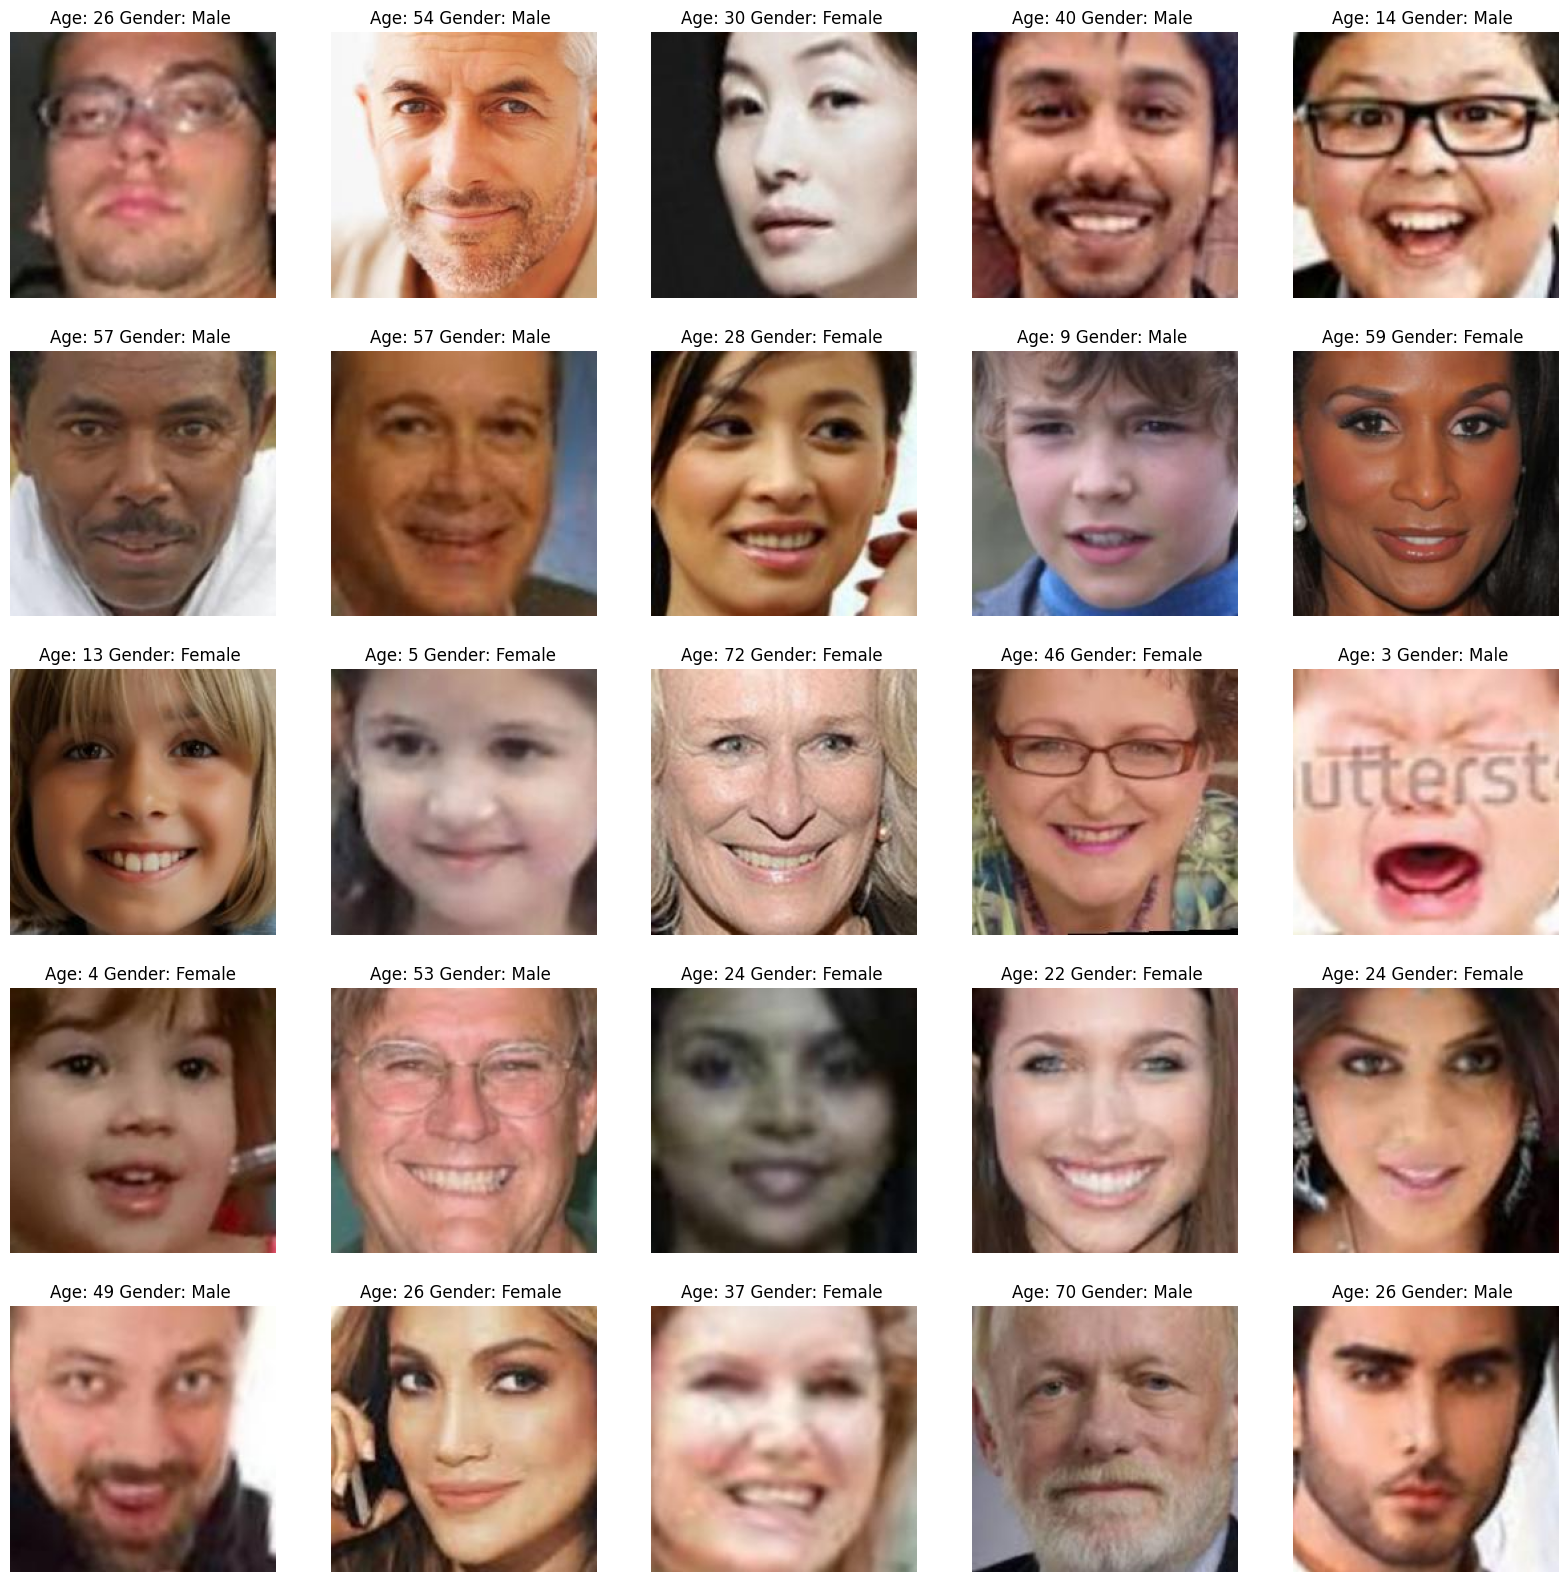

In [8]:
plt.figure(figsize=(20, 20))  #loading first 25 images with there age and gender
files = df.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]} ")
    plt.axis('off')

It can be seen that all images are has there respective gender and age.

### Extract feature from Images

In [9]:
def extract_features(images):  #extraxting features from images
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128,128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features),128,128, 1) #reshape them into (128,128)
    return features

In [10]:
X1 = extract_features(df['image']) #defining image features as our X1

  0%|          | 0/23709 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
<ipython-input-9-14068d922591>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)
100%|██████████| 23709/23709 [00:26<00:00, 896.23it/s] 


In [11]:
X1.shape

(23709, 128, 128, 1)

In [12]:
X = X1/255.0

In [13]:
y = np.array(df['gender'])#defining our label

In [14]:
y2 = np.array(df['age']) #defining our second output of age

## Multi task Model

In [15]:
#splitting data in training and testing
X_train, X_test, y_train, y_test, y2_train, y2_test = train_test_split(X, y, y2, test_size=0.2, random_state=42)

In [16]:
# Custom R2 metric function
def r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2

In [17]:
inputs = Input(shape=(128, 128, 1))  # image input CNN model

# CNN branch
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)
conv_5 = Conv2D(512, kernel_size=(3, 3), activation='relu')(maxp_4)
maxp_5 = MaxPooling2D(pool_size=(2, 2))(conv_5)
flatten = Flatten()(maxp_5)

# Age branch
age_dense_1 = Dense(256, activation='relu')(flatten)
age_dense_2 = Dense(128, activation='relu')(age_dense_1)
age_out = Dense(1, activation='linear', name='age_out')(age_dense_2)

# Gender branch
gender_dense_1 = Dense(256, activation='relu')(flatten)
gender_dense_2 = Dense(128, activation='relu')(gender_dense_1)
gender_out = Dense(1, activation='sigmoid', name='gender_out')(gender_dense_2)


model = Model(inputs=inputs, outputs=[gender_out, age_out])  # defining model inputs and outputs

model.compile(loss=['binary_crossentropy', 'mean_squared_error'],
              optimizer=Adam(lr=1e-4),
              metrics={'gender_out': 'accuracy', 'age_out': r2_score})

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

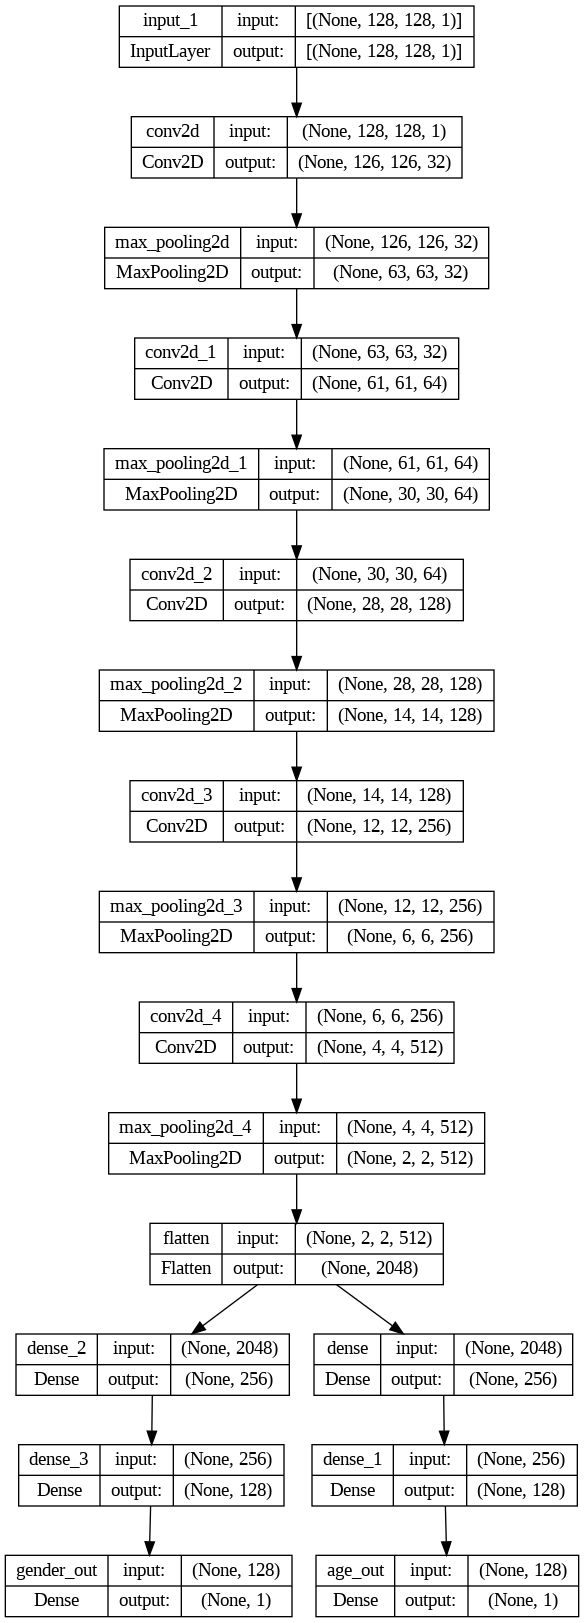

In [18]:
plot_model(model,to_file='model_plot.png', show_shapes=True) #plotting model structure

This modeling system is designed to simultaneously predict sex and age from facial images. It starts with an input image of 128x128 pixels, then uses a series of convolutional layers followed by an activation function to capture the image features. Maximum pooling levels help reduce data reduction while maintaining the required pattern. The shared features fall into two branches: one predicts age using two complex layers and linear activation, the other predicts sex using the same layers with sigmoid activation These branches work together in the model, guided by loss activities that help them learn. The result is a versatile system that can handle both classification (sex) and regression (age) tasks simultaneously

In [19]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-4)

In [20]:
history = model.fit(
    x=X_train,  # training inputs
    y=[y_train, y2_train],  # training outputs
    validation_data=(X_test, [y_test, y2_test]),  # testing data
    batch_size=32,
    epochs=20,
    callbacks=[learn_control]
)

Epoch 1/20
593/593 [==============================] - ETA: 0s - loss: 421.3810 - gender_out_loss: 0.7013 - age_out_loss: 420.6795 - gender_out_accuracy: 0.5238 - age_out_r2_score: -0.1045

593/593 [==============================] - 39s 32ms/step - loss: 421.3810 - gender_out_loss: 0.7013 - age_out_loss: 420.6795 - gender_out_accuracy: 0.5238 - age_out_r2_score: -0.1045 - val_loss: 277.8246 - val_gender_out_loss: 0.5895 - val_age_out_loss: 277.2352 - val_gender_out_accuracy: 0.6906 - val_age_out_r2_score: 0.2433 - lr: 0.0010
Epoch 2/20
592/593 [============================>.] - ETA: 0s - loss: 240.2771 - gender_out_loss: 0.5772 - age_out_loss: 239.7001 - gender_out_accuracy: 0.7048 - age_out_r2_score: 0.3638

593/593 [==============================] - 13s 22ms/step - loss: 240.1977 - gender_out_loss: 0.5773 - age_out_loss: 239.6206 - gender_out_accuracy: 0.7048 - age_out_r2_score: 0.3640 - val_loss: 164.4070 - val_gender_out_loss: 0.5089 - val_age_out_loss: 163.8981 - val_gender_out_accuracy: 0.7550 - val_age_out_r2_score: 0.5419 - lr: 0.0010
Epoch 3/20
593/593 [==============================] - ETA: 0s - loss: 165.5338 - gender_out_loss: 0.5304 - age_out_loss: 165.0033 - gender_out_accuracy: 0.7343 - age_out_r2_score: 0.5556

593/593 [==============================] - 13s 22ms/step - loss: 165.5338 - gender_out_loss: 0.5304 - age_out_loss: 165.0033 - gender_out_accuracy: 0.7343 - age_out_r2_score: 0.5556 - val_loss: 151.3127 - val_gender_out_loss: 0.4911 - val_age_out_loss: 150.8216 - val_gender_out_accuracy: 0.7558 - val_age_out_r2_score: 0.5894 - lr: 0.0010
Epoch 4/20
593/593 [==============================] - ETA: 0s - loss: 126.5929 - gender_out_loss: 0.5001 - age_out_loss: 126.0929 - gender_out_accuracy: 0.7561 - age_out_r2_score: 0.6578

593/593 [==============================] - 13s 21ms/step - loss: 126.5929 - gender_out_loss: 0.5001 - age_out_loss: 126.0929 - gender_out_accuracy: 0.7561 - age_out_r2_score: 0.6578 - val_loss: 107.7461 - val_gender_out_loss: 0.4719 - val_age_out_loss: 107.2742 - val_gender_out_accuracy: 0.7687 - val_age_out_r2_score: 0.6957 - lr: 0.0010
Epoch 5/20
592/593 [============================>.] - ETA: 0s - loss: 103.7667 - gender_out_loss: 0.4603 - age_out_loss: 103.3065 - gender_out_accuracy: 0.7749 - age_out_r2_score: 0.7209

593/593 [==============================] - 13s 22ms/step - loss: 103.7385 - gender_out_loss: 0.4600 - age_out_loss: 103.2785 - gender_out_accuracy: 0.7750 - age_out_r2_score: 0.7210 - val_loss: 96.1324 - val_gender_out_loss: 0.4514 - val_age_out_loss: 95.6810 - val_gender_out_accuracy: 0.7750 - val_age_out_r2_score: 0.7285 - lr: 0.0010
Epoch 6/20
592/593 [============================>.] - ETA: 0s - loss: 86.4494 - gender_out_loss: 0.4397 - age_out_loss: 86.0098 - gender_out_accuracy: 0.7880 - age_out_r2_score: 0.7658

593/593 [==============================] - 13s 22ms/step - loss: 86.4683 - gender_out_loss: 0.4396 - age_out_loss: 86.0287 - gender_out_accuracy: 0.7879 - age_out_r2_score: 0.7658 - val_loss: 95.4764 - val_gender_out_loss: 0.4158 - val_age_out_loss: 95.0605 - val_gender_out_accuracy: 0.8016 - val_age_out_r2_score: 0.7369 - lr: 0.0010
Epoch 7/20
593/593 [==============================] - ETA: 0s - loss: 73.5121 - gender_out_loss: 0.4135 - age_out_loss: 73.0986 - gender_out_accuracy: 0.8023 - age_out_r2_score: 0.8004

593/593 [==============================] - 13s 23ms/step - loss: 73.5121 - gender_out_loss: 0.4135 - age_out_loss: 73.0986 - gender_out_accuracy: 0.8023 - age_out_r2_score: 0.8004 - val_loss: 88.9727 - val_gender_out_loss: 0.4123 - val_age_out_loss: 88.5605 - val_gender_out_accuracy: 0.8060 - val_age_out_r2_score: 0.7497 - lr: 0.0010
Epoch 8/20
592/593 [============================>.] - ETA: 0s - loss: 66.6153 - gender_out_loss: 0.3970 - age_out_loss: 66.2183 - gender_out_accuracy: 0.8074 - age_out_r2_score: 0.8189

593/593 [==============================] - 13s 22ms/step - loss: 66.6632 - gender_out_loss: 0.3972 - age_out_loss: 66.2659 - gender_out_accuracy: 0.8073 - age_out_r2_score: 0.8189 - val_loss: 87.5434 - val_gender_out_loss: 0.4212 - val_age_out_loss: 87.1222 - val_gender_out_accuracy: 0.7959 - val_age_out_r2_score: 0.7504 - lr: 0.0010
Epoch 9/20
591/593 [============================>.] - ETA: 0s - loss: 56.8564 - gender_out_loss: 0.3817 - age_out_loss: 56.4748 - gender_out_accuracy: 0.8165 - age_out_r2_score: 0.8458

593/593 [==============================] - 17s 28ms/step - loss: 56.8395 - gender_out_loss: 0.3817 - age_out_loss: 56.4579 - gender_out_accuracy: 0.8163 - age_out_r2_score: 0.8458 - val_loss: 94.1057 - val_gender_out_loss: 0.3708 - val_age_out_loss: 93.7349 - val_gender_out_accuracy: 0.8174 - val_age_out_r2_score: 0.7368 - lr: 0.0010
Epoch 10/20
592/593 [============================>.] - ETA: 0s - loss: 48.6500 - gender_out_loss: 0.3729 - age_out_loss: 48.2771 - gender_out_accuracy: 0.8203 - age_out_r2_score: 0.8667

593/593 [==============================] - 13s 22ms/step - loss: 48.6291 - gender_out_loss: 0.3729 - age_out_loss: 48.2563 - gender_out_accuracy: 0.8203 - age_out_r2_score: 0.8668 - val_loss: 87.2945 - val_gender_out_loss: 0.3701 - val_age_out_loss: 86.9244 - val_gender_out_accuracy: 0.8167 - val_age_out_r2_score: 0.7558 - lr: 0.0010
Epoch 11/20
593/593 [==============================] - ETA: 0s - loss: 40.8812 - gender_out_loss: 0.3716 - age_out_loss: 40.5095 - gender_out_accuracy: 0.8188 - age_out_r2_score: 0.8879

593/593 [==============================] - 14s 23ms/step - loss: 40.8812 - gender_out_loss: 0.3716 - age_out_loss: 40.5095 - gender_out_accuracy: 0.8188 - age_out_r2_score: 0.8879 - val_loss: 77.9720 - val_gender_out_loss: 0.3821 - val_age_out_loss: 77.5899 - val_gender_out_accuracy: 0.8096 - val_age_out_r2_score: 0.7760 - lr: 0.0010
Epoch 12/20
592/593 [============================>.] - ETA: 0s - loss: 37.3574 - gender_out_loss: 0.3614 - age_out_loss: 36.9960 - gender_out_accuracy: 0.8256 - age_out_r2_score: 0.8966

593/593 [==============================] - 14s 24ms/step - loss: 37.3574 - gender_out_loss: 0.3613 - age_out_loss: 36.9961 - gender_out_accuracy: 0.8257 - age_out_r2_score: 0.8966 - val_loss: 93.3622 - val_gender_out_loss: 0.3702 - val_age_out_loss: 92.9920 - val_gender_out_accuracy: 0.8180 - val_age_out_r2_score: 0.7360 - lr: 0.0010
Epoch 13/20
592/593 [============================>.] - ETA: 0s - loss: 32.2535 - gender_out_loss: 0.3511 - age_out_loss: 31.9023 - gender_out_accuracy: 0.8318 - age_out_r2_score: 0.9130

593/593 [==============================] - 13s 22ms/step - loss: 32.2582 - gender_out_loss: 0.3513 - age_out_loss: 31.9069 - gender_out_accuracy: 0.8318 - age_out_r2_score: 0.9130 - val_loss: 83.0151 - val_gender_out_loss: 0.3531 - val_age_out_loss: 82.6620 - val_gender_out_accuracy: 0.8288 - val_age_out_r2_score: 0.7604 - lr: 0.0010
Epoch 14/20
591/593 [============================>.] - ETA: 0s - loss: 27.0592 - gender_out_loss: 0.3447 - age_out_loss: 26.7145 - gender_out_accuracy: 0.8337 - age_out_r2_score: 0.9254

593/593 [==============================] - 13s 22ms/step - loss: 27.1144 - gender_out_loss: 0.3448 - age_out_loss: 26.7696 - gender_out_accuracy: 0.8337 - age_out_r2_score: 0.9253 - val_loss: 75.8995 - val_gender_out_loss: 0.3490 - val_age_out_loss: 75.5506 - val_gender_out_accuracy: 0.8326 - val_age_out_r2_score: 0.7833 - lr: 0.0010
Epoch 15/20
593/593 [==============================] - ETA: 0s - loss: 25.7722 - gender_out_loss: 0.3352 - age_out_loss: 25.4370 - gender_out_accuracy: 0.8423 - age_out_r2_score: 0.9293

593/593 [==============================] - 13s 22ms/step - loss: 25.7722 - gender_out_loss: 0.3352 - age_out_loss: 25.4370 - gender_out_accuracy: 0.8423 - age_out_r2_score: 0.9293 - val_loss: 83.7628 - val_gender_out_loss: 0.3506 - val_age_out_loss: 83.4123 - val_gender_out_accuracy: 0.8317 - val_age_out_r2_score: 0.7657 - lr: 0.0010
Epoch 16/20
591/593 [============================>.] - ETA: 0s - loss: 23.1710 - gender_out_loss: 0.3332 - age_out_loss: 22.8378 - gender_out_accuracy: 0.8419 - age_out_r2_score: 0.9363

593/593 [==============================] - 15s 25ms/step - loss: 23.1947 - gender_out_loss: 0.3328 - age_out_loss: 22.8619 - gender_out_accuracy: 0.8421 - age_out_r2_score: 0.9363 - val_loss: 75.0128 - val_gender_out_loss: 0.3430 - val_age_out_loss: 74.6698 - val_gender_out_accuracy: 0.8364 - val_age_out_r2_score: 0.7874 - lr: 0.0010
Epoch 17/20
592/593 [============================>.] - ETA: 0s - loss: 21.4399 - gender_out_loss: 0.3234 - age_out_loss: 21.1164 - gender_out_accuracy: 0.8476 - age_out_r2_score: 0.9411

593/593 [==============================] - 13s 22ms/step - loss: 21.4322 - gender_out_loss: 0.3234 - age_out_loss: 21.1088 - gender_out_accuracy: 0.8476 - age_out_r2_score: 0.9411 - val_loss: 79.3529 - val_gender_out_loss: 0.3394 - val_age_out_loss: 79.0135 - val_gender_out_accuracy: 0.8404 - val_age_out_r2_score: 0.7733 - lr: 0.0010
Epoch 18/20
593/593 [==============================] - ETA: 0s - loss: 19.0950 - gender_out_loss: 0.3146 - age_out_loss: 18.7804 - gender_out_accuracy: 0.8511 - age_out_r2_score: 0.9479

593/593 [==============================] - 13s 22ms/step - loss: 19.0950 - gender_out_loss: 0.3146 - age_out_loss: 18.7804 - gender_out_accuracy: 0.8511 - age_out_r2_score: 0.9479 - val_loss: 75.2138 - val_gender_out_loss: 0.3296 - val_age_out_loss: 74.8841 - val_gender_out_accuracy: 0.8471 - val_age_out_r2_score: 0.7870 - lr: 0.0010
Epoch 19/20
591/593 [============================>.] - ETA: 0s - loss: 18.3354 - gender_out_loss: 0.3132 - age_out_loss: 18.0221 - gender_out_accuracy: 0.8532 - age_out_r2_score: 0.9499

593/593 [==============================] - 13s 22ms/step - loss: 18.3304 - gender_out_loss: 0.3134 - age_out_loss: 18.0170 - gender_out_accuracy: 0.8530 - age_out_r2_score: 0.9499 - val_loss: 83.2809 - val_gender_out_loss: 0.3358 - val_age_out_loss: 82.9451 - val_gender_out_accuracy: 0.8412 - val_age_out_r2_score: 0.7661 - lr: 0.0010
Epoch 20/20
592/593 [============================>.] - ETA: 0s - loss: 15.8367 - gender_out_loss: 0.3070 - age_out_loss: 15.5297 - gender_out_accuracy: 0.8585 - age_out_r2_score: 0.9564

593/593 [==============================] - 14s 24ms/step - loss: 15.8341 - gender_out_loss: 0.3071 - age_out_loss: 15.5270 - gender_out_accuracy: 0.8585 - age_out_r2_score: 0.9564 - val_loss: 75.9213 - val_gender_out_loss: 0.3317 - val_age_out_loss: 75.5896 - val_gender_out_accuracy: 0.8499 - val_age_out_r2_score: 0.7834 - lr: 0.0010


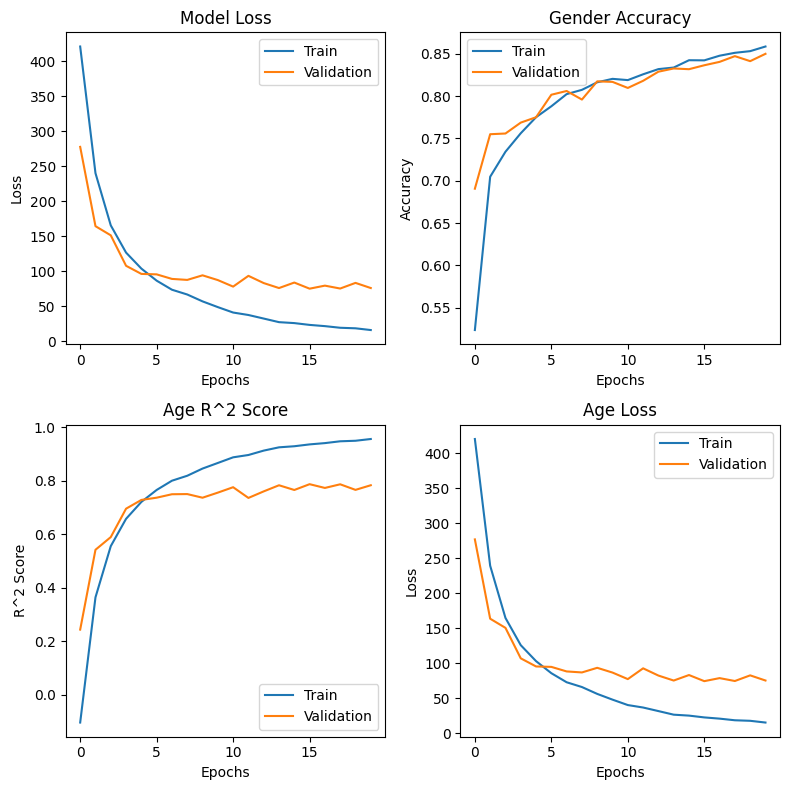

In [21]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # 3 rows, 2 columns

# Plot loss
axs[0, 0].plot(history.history['loss'])
axs[0, 0].plot(history.history['val_loss'])
axs[0, 0].set_title('Model Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend(['Train', 'Validation'])

# Plot gender accuracy
axs[0, 1].plot(history.history['gender_out_accuracy'])
axs[0, 1].plot(history.history['val_gender_out_accuracy'])
axs[0, 1].set_title('Gender Accuracy')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend(['Train', 'Validation'])

# Plot age R^2 score
axs[1, 0].plot(history.history['age_out_r2_score'])
axs[1, 0].plot(history.history['val_age_out_r2_score'])
axs[1, 0].set_title('Age R^2 Score')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('R^2 Score')
axs[1, 0].legend(['Train', 'Validation'])

# Plot age loss
axs[1, 1].plot(history.history['age_out_loss'])
axs[1, 1].plot(history.history['val_age_out_loss'])
axs[1, 1].set_title('Age Loss')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend(['Train', 'Validation'])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


## Model Evaluation

In [22]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save('model.h5')

In [23]:
# Evaluate the model on test data for gender and age
gender_pred, age_pred = model.predict(X_test)

149/149 [==============================] - 2s 6ms/step


In [24]:
gender_preds = (gender_pred > 0.5).astype(int) #rounding of the predicted value

In [25]:
# Generate classification report with class names
gender_class_names = ['Female', 'Male']  # Add the gender class names
classification_rep = classification_report(y_test, gender_preds, target_names=gender_class_names)
print("Gender Classification Report:")
print(classification_rep)

Gender Classification Report:
              precision    recall  f1-score   support

      Female       0.82      0.91      0.86      2471
        Male       0.89      0.79      0.83      2271

    accuracy                           0.85      4742
   macro avg       0.85      0.85      0.85      4742
weighted avg       0.85      0.85      0.85      4742



Text(50.722222222222214, 0.5, 'True')

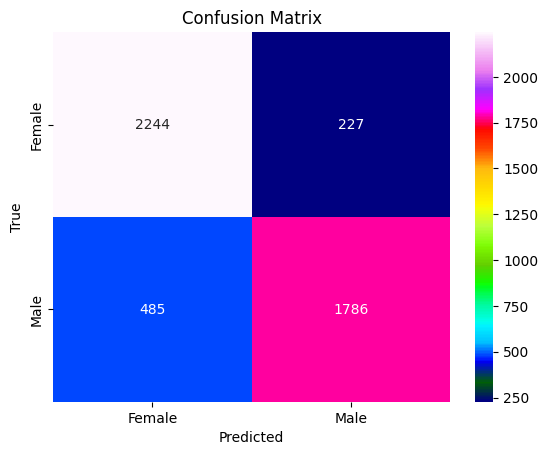

In [26]:
# Plot confusion matrix heatmap with class names

confusion_matrix = confusion_matrix(y_test,gender_preds)
gender_names = ['Female', 'Male']  # Add the gender class names
sns.heatmap(confusion_matrix, annot=True, cmap='gist_ncar', fmt='g', xticklabels=gender_names, yticklabels=gender_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

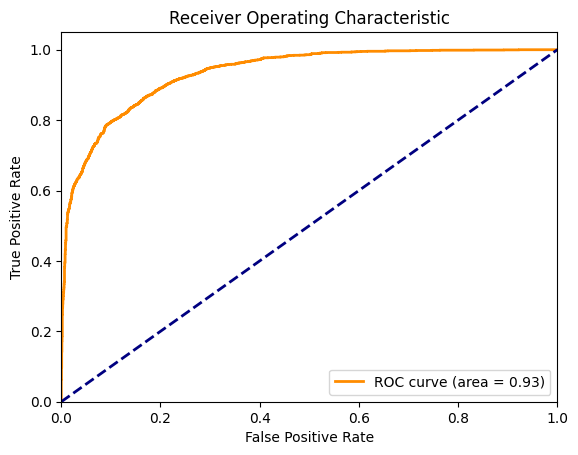

AUC: 0.9338858276928266


In [30]:
# predicted probabilities for the 'Male' class
fpr, tpr, _ = roc_curve(y_test, gender_pred)  # Using probabilities for the 'Male' class
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)

Analysis of the gender classification function of our model reveals promising results. With an overall accuracy of 85%, the model exhibits balanced performance in predicting both sexes. It demonstrates greater accuracy in predicting females (82%) compared to males (89%), while maintaining a respectable recall rate of 91% for females and 79% for males This is consistent with the average rate, with a balance of precision and recall at 85 %. The confusion matrix visually represents the predictions of the model, and demonstrates its ability to correctly classify a large proportion of women and men while not under-classifying Furthermore, an impressive AUC score of 0.93 for the ROC the curve highlights the strong ability of the model to predict gender differences was predicted to be successful.

In [ ]:
# Calculate MSE
age_mse = mean_squared_error(y2_test, age_pred)

# Calculate MAE
age_mae = mean_absolute_error(y2_test, age_pred)

# Calculate R^2 score
age_r2 = r2_score(y2_test, age_pred)

# Print the evaluation metrics
print("Age Prediction Evaluation Metrics:")
print("MSE:", age_mse)
print("MAE:", age_mae)
print("R^2 Score:", age_r2)

Age Prediction Evaluation Metrics:
MSE: 78.03353146205822
MAE: 6.14341801768212
R^2 Score: 0.7969254368397732


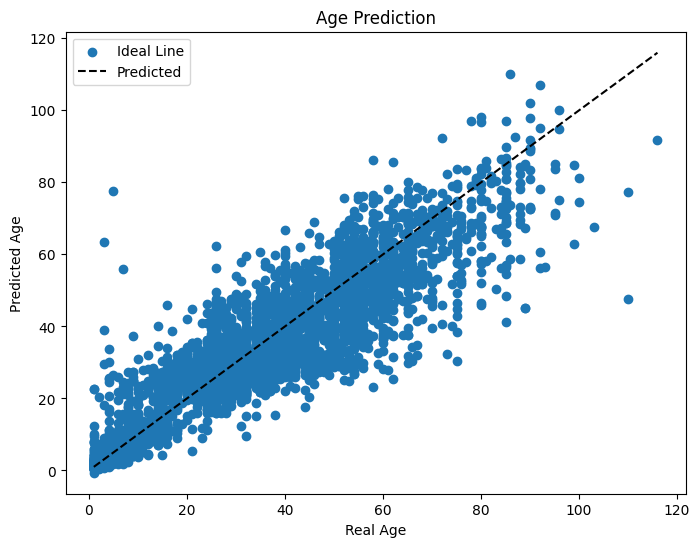

In [ ]:
# Plot real and predicted age values
plt.figure(figsize=(8, 6))
plt.scatter(y2_test, age_pred)
plt.plot([np.min(y2_test), np.max(y2_test)], [np.min(y2_test), np.max(y2_test)], 'k--')
plt.xlabel('Real Age')
plt.ylabel('Predicted Age')
plt.title('Age Prediction')
plt.legend(['Ideal Line', 'Predicted'])
plt.show()

The metrics provided by the age model are as follows.

**1-mean square error (MSE): 78.03**

**2-mean absolute error (MAE): 6.14** .

**3-R-Square Score: 0.80**

Together, these measures demonstrate the effectiveness of the model in estimating age from facial expression. The lowest MSE and MAE values confirm the accuracy of age prediction, while R-square scores indicate that approximately 80% of the age variance is explained by the model.

As we have done looking at model performance, now we wil take some random images from dataset and make prediction on that and see what are real and prediction our model given.

1/1 [==============================] - 0s 379ms/step


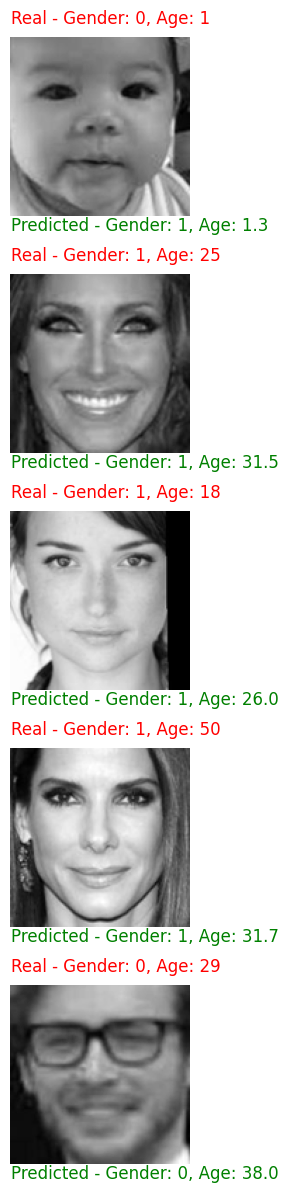

In [ ]:
## Select 5 random images from the test data
num_images = 5
random_indices = np.random.choice(len(X_test), num_images, replace=False)
selected_images = X_test[random_indices]
selected_gender_labels = y_test[random_indices]
selected_age_labels = y2_test[random_indices]

# Make predictions for selected images
selected_gender_preds, selected_age_preds = model.predict(selected_images)

# Convert gender predictions to class labels
selected_gender_preds_classes = (selected_gender_preds > 0.5).astype(int)


# Display the images with their predicted and real age and gender
fig, axs = plt.subplots(num_images, 1, figsize=(8, 12))

for i in range(num_images):
    # Display the image
    axs[i].imshow(selected_images[i].squeeze(), cmap='gray')
    axs[i].axis('off')

    # Construct the label string
    real_label = f"Real - Gender: {selected_gender_labels[i]}, Age: {selected_age_labels[i]}"
    pred_label = f"Predicted - Gender: {selected_gender_preds_classes[i].item()}, Age: {selected_age_preds[i].item():.1f}"

    # Display the labels
    axs[i].text(0, -10, real_label, fontsize=12, color='red')
    axs[i].text(0, selected_images[i].shape[0] + 10, pred_label, fontsize=12, color='green')

plt.tight_layout()
plt.show()

# Conclusion

Our model shines in accurate sex identification, achieving a commendable 85% accuracy. It excels at distinguishing between genders, showing greater accuracy for women (82%) than men (89%). It maintains a strong recall rate of 91% for females and 79% for males, reflected in a balanced accuracy of 85%. The confusion matrix highlights its ability to correctly classify a large proportion of both males and females with minimal misclassification.

When predicting different seasons, our model shows promise, making predictions that are more consistent with actual seasons. These results open the way for interesting developments. Refining the model to capture specific gender-based factors while addressing potential gender prediction biases remains future development.

Analyzing more detailed samples and adding more complexity to age prediction could increase accuracy. This anticipated a more accurate age estimate.

Furthermore, our efforts extend beyond model development. By implementing it as a user-friendly web application using Flask, we bring the predictability of our model to a wider audience. This accessible platform really shows the impact of our work.

In summary, the success of our model in gender-specific age prediction tasks highlights its practical utility. Further configuration and analysis contains the potential for different applications, reflecting the journey of the project from analysis to real-world implementation.